In [ ]:
# Notebook 2: 5 Features Analysis

# this notebook tests the QSVC and classical SVC models using the top 5 features most correlated with the label.

In [1]:
# load data
import csv
import numpy as np
import pandas as pd

filename = "datasets/Thyroid_Diff.csv"
with open(filename, 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    data = [row for row in reader]

data = np.array(data, dtype=object)

# split features from labels
X = data[:, :-1]    # features
y = data[:, -1]     # labels

In [2]:
X[0]

array(['27', 'F', 'No', 'No', 'No', 'Euthyroid',
       'Single nodular goiter-left', 'No', 'Micropapillary', 'Uni-Focal',
       'Low', 'T1a', 'N0', 'M0', 'I', 'Indeterminate'], dtype=object)

In [3]:
# converts string values into integers 
from sklearn.preprocessing import LabelEncoder

# encode X
for i in range(X.shape[1]):
    le = LabelEncoder()
    X[:, i] = le.fit_transform(X[:, i])

X = X.astype(float)

# encode y
y_le = LabelEncoder()
y = y_le.fit_transform(y)

In [4]:
# convert to pandas so correlation works
X_df = pd.DataFrame(X)
y_s = pd.Series(y)

# compute correlation
correlations = X_df.apply(lambda col: col.corr(y_s))
correlations_abs = correlations.abs().sort_values(ascending=False)

print("\nPEARSON CORRELATIONS (ABS SORTED)")
print(correlations_abs)

# select top-k features
top2 = correlations_abs.head(2).index.tolist()
top5 = correlations_abs.head(5).index.tolist()
top10 = correlations_abs.head(10).index.tolist()

print("\nTop 2 features:", top2)
print("Top 5 features:", top5)
print("Top 10 features:", top10)



PEARSON CORRELATIONS (ABS SORTED)
10    0.733376
15    0.708957
12    0.632323
11    0.556201
14    0.449137
9     0.383776
13    0.354360
2     0.333243
1     0.328189
0     0.257659
7     0.182530
4     0.174407
3     0.136073
6     0.131801
5     0.067758
8     0.003272
dtype: float64

Top 2 features: [10, 15]
Top 5 features: [10, 15, 12, 11, 14]
Top 10 features: [10, 15, 12, 11, 14, 9, 13, 2, 1, 0]


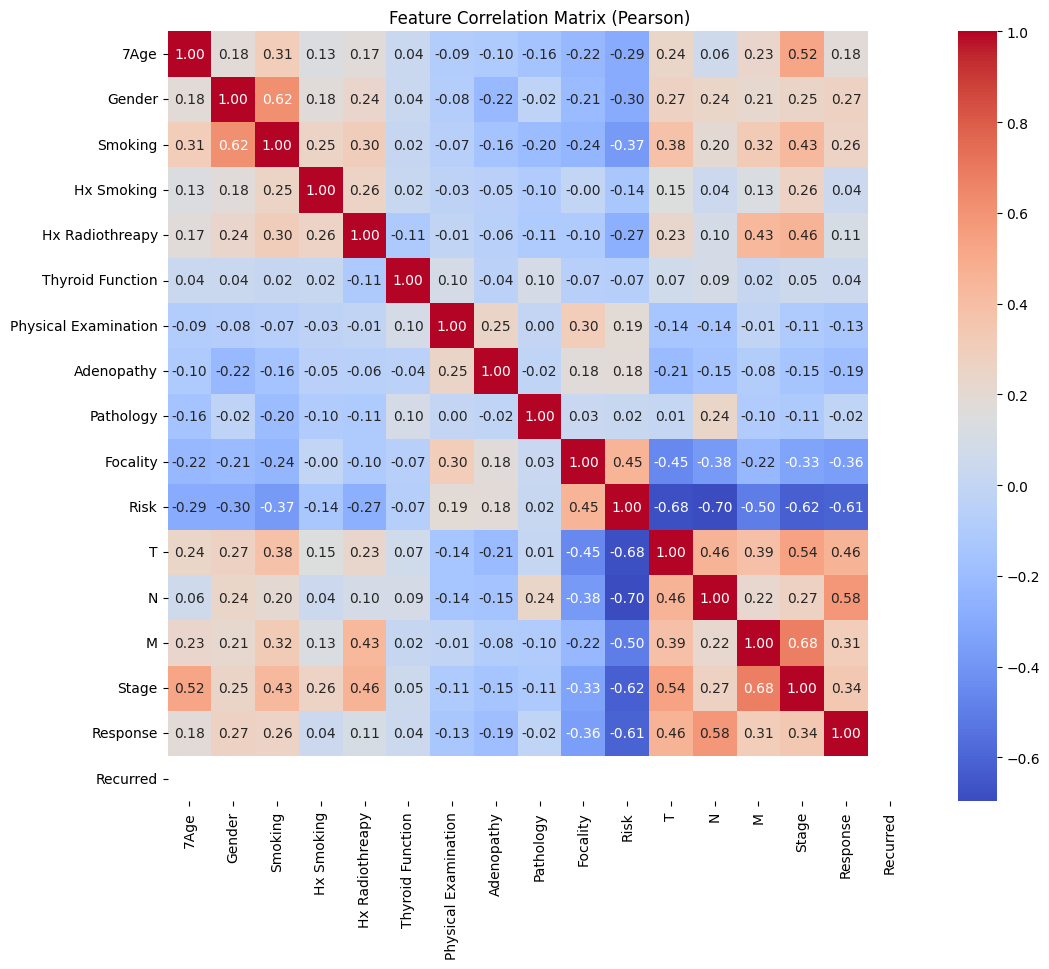

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# convert numpy array -> DataFrame
df = pd.DataFrame(data, columns=header)

# convert to numeric only (Pearson needs numbers)
df_numeric = df.apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(12, 10))
corr_matrix = df_numeric.corr()

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix (Pearson)")
plt.show()


In [7]:
from sklearn.model_selection import train_test_split

# how many features to use
X = X[:, top5]     # <-- CHANGE THIS (top2, top5, top10)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [8]:
# basic printing and shape checking to confirm dataset size
print(X[0])
print("Shape X:",X.shape)
print("Shape y:", y.shape)

X_new = X[:][0:2]
print("Shape X:",X_new.shape)


[2. 2. 0. 0. 0.]
Shape X: (383, 5)
Shape y: (383,)
Shape X: (2, 5)


In [9]:
# MODEL 1: QSVC + QuantumKernel (main baseline model)
from sklearn.utils import resample
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityStatevectorKernel
from qiskit_machine_learning.algorithms import QSVC

# reduce for speed
X_small, y_small = resample(X_train, y_train, n_samples=300, random_state=42)
X_test_small = X_test[:100]
y_test_small = y_test[:100]

# quantum feature map
feature_map = ZZFeatureMap(feature_dimension=X_small.shape[1], reps=1)

quantum_kernel = FidelityStatevectorKernel(feature_map=feature_map)

qsvc = QSVC(quantum_kernel=quantum_kernel)
qsvc.fit(X_small, y_small)

score_qsvc = qsvc.score(X_test_small, y_test_small)
print("\nQSVC accuracy:", score_qsvc)




QSVC accuracy: 0.961038961038961


In [10]:
# this measures how long it takes to train the QSVC model
# DOES NOT AFFECT ACCURACY

import time
start = time.time()
qsvc.fit(X_small, y_small)
print("Training took", time.time() - start, "seconds")



Training took 0.6084835529327393 seconds


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def evaluate_model(y_true, y_pred, model_name="Model"):
    print(f"\n Evaluation Metrics: {model_name} ")
    print("Accuracy: ", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:   ", recall_score(y_true, y_pred))
    print("F1-Score: ", f1_score(y_true, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))


In [12]:
y_pred_qsvc = qsvc.predict(X_test_small)
evaluate_model(y_test_small, y_pred_qsvc, "QSVC")



 Evaluation Metrics: QSVC 
Accuracy:  0.961038961038961
Precision: 0.9444444444444444
Recall:    0.8947368421052632
F1-Score:  0.918918918918919

Confusion Matrix:
[[57  1]
 [ 2 17]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97        58
           1       0.94      0.89      0.92        19

    accuracy                           0.96        77
   macro avg       0.96      0.94      0.95        77
weighted avg       0.96      0.96      0.96        77



In [13]:
# MODEL 2: Classical SVC (RBF baseline)
# this is the normal, classical SVC
# this is a good baseline to compare how good the quantum methods are
from sklearn.svm import SVC

svc_rbf = SVC(kernel="rbf")
svc_rbf.fit(X_small, y_small)

score_rbf = svc_rbf.score(X_test_small, y_test_small)
print("Classical SVC (RBF) accuracy:", score_rbf)



Classical SVC (RBF) accuracy: 0.961038961038961


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def evaluate_model(y_true, y_pred, model_name="Model"):
    print(f"\n Evaluation Metrics: {model_name} ")
    print("Accuracy: ", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:   ", recall_score(y_true, y_pred))
    print("F1-Score: ", f1_score(y_true, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

In [15]:
y_pred_qsvc = qsvc.predict(X_test_small)
evaluate_model(y_test_small, y_pred_qsvc, "Classical SVC")


 Evaluation Metrics: Classical SVC 
Accuracy:  0.961038961038961
Precision: 0.9444444444444444
Recall:    0.8947368421052632
F1-Score:  0.918918918918919

Confusion Matrix:
[[57  1]
 [ 2 17]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97        58
           1       0.94      0.89      0.92        19

    accuracy                           0.96        77
   macro avg       0.96      0.94      0.95        77
weighted avg       0.96      0.96      0.96        77



In [16]:
# MODEL 3: Classical SVC + Quantum Kernel as a callable
# the classical SVC calls the quantum kernel during training

svc_callable = SVC(kernel=quantum_kernel.evaluate)
svc_callable.fit(X_small, y_small)

score_callable = svc_callable.score(X_test_small, y_test_small)
print("Callable SVC + Quantum Kernel accuracy:", score_callable)



Callable SVC + Quantum Kernel accuracy: 0.961038961038961


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def evaluate_model(y_true, y_pred, model_name="Model"):
    print(f"\n Evaluation Metrics: {model_name} ")
    print("Accuracy: ", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:   ", recall_score(y_true, y_pred))
    print("F1-Score: ", f1_score(y_true, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

In [18]:
y_pred_qsvc = qsvc.predict(X_test_small)
evaluate_model(y_test_small, y_pred_qsvc, "Classical SVC + Quantum Kernel")


 Evaluation Metrics: Classical SVC + Quantum Kernel 
Accuracy:  0.961038961038961
Precision: 0.9444444444444444
Recall:    0.8947368421052632
F1-Score:  0.918918918918919

Confusion Matrix:
[[57  1]
 [ 2 17]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97        58
           1       0.94      0.89      0.92        19

    accuracy                           0.96        77
   macro avg       0.96      0.94      0.95        77
weighted avg       0.96      0.96      0.96        77



In [19]:
# MODEL 4: Classical SVC using precomputed Quantum Kernel
# SVC + QuantumTrainableKernel (Precomputed)
# the quantum kernel matrix is computed BEFORE training

# this is the quantum kernel matrix calculation
K_train = quantum_kernel.evaluate(X_small)
K_test  = quantum_kernel.evaluate(X_test_small, X_small)

svc_pre = SVC(kernel="precomputed")
svc_pre.fit(K_train, y_small)

score_pre = svc_pre.score(K_test, y_test_small)
print("Precomputed SVC + Quantum Kernel accuracy:", score_pre)

Precomputed SVC + Quantum Kernel accuracy: 0.961038961038961


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def evaluate_model(y_true, y_pred, model_name="Model"):
    print(f"\n Evaluation Metrics: {model_name} ")
    print("Accuracy: ", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:   ", recall_score(y_true, y_pred))
    print("F1-Score: ", f1_score(y_true, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

In [21]:
y_pred_qsvc = qsvc.predict(X_test_small)
evaluate_model(y_test_small, y_pred_qsvc, "Classical SVC")


 Evaluation Metrics: Classical SVC 
Accuracy:  0.961038961038961
Precision: 0.9444444444444444
Recall:    0.8947368421052632
F1-Score:  0.918918918918919

Confusion Matrix:
[[57  1]
 [ 2 17]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97        58
           1       0.94      0.89      0.92        19

    accuracy                           0.96        77
   macro avg       0.96      0.94      0.95        77
weighted avg       0.96      0.96      0.96        77



In [22]:
# MODEL 5: Trainable Quantum Kernel

# external imports 
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_machine_learning.optimizers import SPSA
from qiskit_machine_learning.algorithms import QSVC
from sklearn.svm import SVC
from sklearn import metrics
from qiskit.visualization import circuit_drawer
import numpy as np

class QKTCallback:
    def __init__(self):
        self._data = [[] for _ in range(5)]

    def callback(self, x0, x1=None, x2=None, x3=None, x4=None):
        self._data[0].append(x0)
        self._data[1].append(x1)
        self._data[2].append(x2)
        self._data[3].append(x3)
        self._data[4].append(x4)

    def get_callback_data(self):
        return self._data

    def clear_callback_data(self):
        self._data = [[] for _ in range(5)]




In [23]:
# SECTION 1 — Feature Map + Trainable Kernel + SPSA + Trainer


num_features = X_train.shape[1]  # e.g., 5 features

# trainable rotation layer: one parameter per qubit
fm0 = QuantumCircuit(num_features)
training_params = ParameterVector("θ", num_features)

for q in range(num_features):
    fm0.ry(training_params[q], q)

# add simple entangling layer (linear chain)
for i in range(num_features - 1):
    fm0.cx(i, i+1)

# static ZZFeatureMap 
fm1 = ZZFeatureMap(num_features, reps=1, entanglement='linear')

# compose trainable + fixed map
fm = fm0.compose(fm1)

print(circuit_drawer(fm))
print(f"Trainable parameters: {training_params}")

# trainable kernel 
from qiskit.primitives import Sampler
sampler = Sampler()

quant_kernel = TrainableFidelityQuantumKernel(
    feature_map=fm,
    training_parameters=training_params
)

# SPSA optimizer
cb_qkt = QKTCallback()
spsa_opt = SPSA(
    maxiter=15,
    callback=cb_qkt.callback,
    learning_rate=0.05,
    perturbation=0.05
)

# kernel trainer 
initial_point = np.random.rand(num_features) * np.pi
qkt = QuantumKernelTrainer(
    quantum_kernel=quant_kernel,
    loss="svc_loss",
    optimizer=spsa_opt,
    initial_point=initial_point
)


     ┌──────────┐                    »
q_0: ┤ Ry(θ[0]) ├──■─────────────────»
     ├──────────┤┌─┴─┐               »
q_1: ┤ Ry(θ[1]) ├┤ X ├──■────────────»
     ├──────────┤└───┘┌─┴─┐          »
q_2: ┤ Ry(θ[2]) ├─────┤ X ├──■───────»
     ├──────────┤     └───┘┌─┴─┐     »
q_3: ┤ Ry(θ[3]) ├──────────┤ X ├──■──»
     ├──────────┤          └───┘┌─┴─┐»
q_4: ┤ Ry(θ[4]) ├───────────────┤ X ├»
     └──────────┘               └───┘»
«     ┌─────────────────────────────────────────┐
«q_0: ┤0                                        ├
«     │                                         │
«q_1: ┤1                                        ├
«     │                                         │
«q_2: ┤2 ZZFeatureMap(x[0],x[1],x[2],x[3],x[4]) ├
«     │                                         │
«q_3: ┤3                                        ├
«     │                                         │
«q_4: ┤4                                        ├
«     └─────────────────────────────────────────┘
Trainable parameters:

/tmp/ipykernel_508/420280094.py:28: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


In [24]:
# SECTION 2 — Subset + Training Trainable Kernel

# use a small subset of training samples to reduce runtime
subset_idx = np.random.choice(len(X_small), size=50, replace=False)
X_subset = X_small[subset_idx]
y_subset = y_small[subset_idx]

print("Training trainable quantum kernel on subset...")
qka_results = qkt.fit(X_subset, y_subset)

optimized_kernel = qka_results.quantum_kernel
print(qka_results)



Training trainable quantum kernel on subset...
{   'optimal_circuit': None,
    'optimal_parameters': {   ParameterVectorElement(θ[0]): np.float64(3.060769153868732),
                              ParameterVectorElement(θ[1]): np.float64(2.653985585156835),
                              ParameterVectorElement(θ[2]): np.float64(0.47804978923013697),
                              ParameterVectorElement(θ[3]): np.float64(2.794027556861202),
                              ParameterVectorElement(θ[4]): np.float64(0.261623175403483)},
    'optimal_point': array([3.06076915, 2.65398559, 0.47804979, 2.79402756, 0.26162318]),
    'optimal_value': np.float64(10.345850413936533),
    'optimizer_evals': 45,
    'optimizer_result': None,
    'optimizer_time': None,
    'quantum_kernel': <qiskit_machine_learning.kernels.trainable_fidelity_quantum_kernel.TrainableFidelityQuantumKernel object at 0x7ab7c7dbcf20>}


In [25]:
# SECTION 3 — QSVC + Classical SVC Using the Optimized Kernel


# Quantum SVC


# create a QSVC using the quantum kernel that was optimized earlier
qsvc = QSVC(quantum_kernel=optimized_kernel)

# fit the QSVC model on the small training set
qsvc.fit(X_small, y_small)

# we use the trained QSVC to predict labels on the test set
labels_test = qsvc.predict(X_test_small)

# calculate balanced accuracy on the test set
accuracy_test = metrics.balanced_accuracy_score(y_true=y_test_small, y_pred=labels_test)
print(f"Trainable kernel QSVC test accuracy: {accuracy_test:.3f}")



# Hybrid SVC + Optimal Quantum Kernel (fixed version)


# using a small subset of training data to keep runtime reasonable
subset_idx = np.random.choice(len(X_small), size=50, replace=False)
X_train_small = X_small[subset_idx]
y_train_small = y_small[subset_idx]

# precompute kernel matrices
# K_train: kernel values between training samples
# K_test: kernel values between test samples and training samples
adhoc_matrix_train = optimized_kernel.evaluate(X_train_small)
adhoc_matrix_test  = optimized_kernel.evaluate(X_test_small, X_train_small)

# train a classical SVC using the precomputed quantum kernel
adhoc_svc = SVC(kernel="precomputed")
adhoc_svc.fit(adhoc_matrix_train, y_train_small)

# evaluate the classical SVC on the test kernel matrix
adhoc_score_precomputed_kernel = adhoc_svc.score(
    adhoc_matrix_test,
    y_test_small
)
print(f"Hybrid SVC (precomputed optimal kernel) test score: {adhoc_score_precomputed_kernel:.3f}")



# Classical SVC (full precomputed kernel)


# optional: slower version, but it uses the same subset for consistency
K_train = optimized_kernel.evaluate(X_train_small)
K_test  = optimized_kernel.evaluate(X_test_small, X_train_small)

# train classical SVC on precomputed kernel
svc_pre = SVC(kernel="precomputed")
svc_pre.fit(K_train, y_train_small)

# evaluate accuracy on test set
pre_score = svc_pre.score(K_test, y_test_small)
print(f"Precomputed kernel classification test score: {pre_score:.3f}")


Trainable kernel QSVC test accuracy: 0.930
Hybrid SVC (precomputed optimal kernel) test score: 0.831
Precomputed kernel classification test score: 0.831


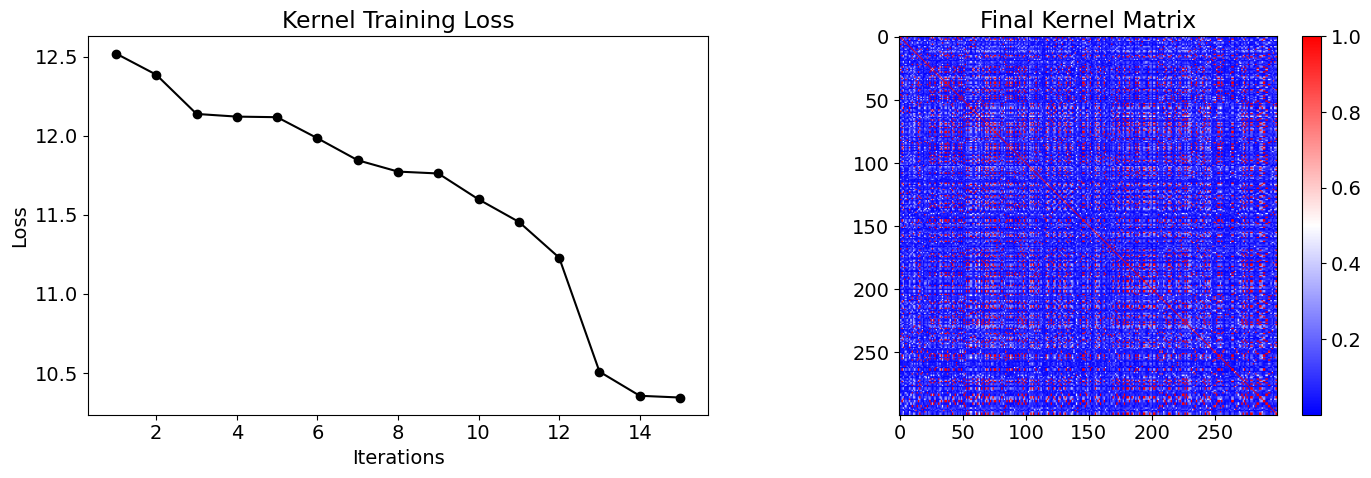

Main Qiskit version:
1.4.5

Installed Qiskit packages:
qiskit 1.4.5
qiskit-machine-learning 0.8.4


/tmp/ipykernel_508/563857719.py:30: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [26]:
# SECTION 4 — Visualize the Kernel Training Process

import matplotlib.pyplot as plt
import matplotlib
import numpy as np

# 1️. plot loss evolution from the callback
plot_data = cb_qkt.get_callback_data()  # callback data from SPSA optimizer

plt.rcParams["font.size"] = 14
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# loss vs iterations
ax[0].plot([i + 1 for i in range(len(plot_data[0]))], np.array(plot_data[2]), c="k", marker="o")
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[0].set_title("Kernel Training Loss")

# kernel matrix heatmap
K = optimized_kernel.evaluate(X_small)  # or X_train_small
im = ax[1].imshow(K, cmap=matplotlib.colormaps["bwr"])
ax[1].set_title("Final Kernel Matrix")
fig.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)

fig.tight_layout()
plt.show()

# 2️. display Qiskit version and installed packages
import qiskit
import pkg_resources

print("Main Qiskit version:")
print(qiskit.__version__)

print("\nInstalled Qiskit packages:")
for pkg in pkg_resources.working_set:
    if "qiskit" in pkg.key:
        print(pkg.key, pkg.version)